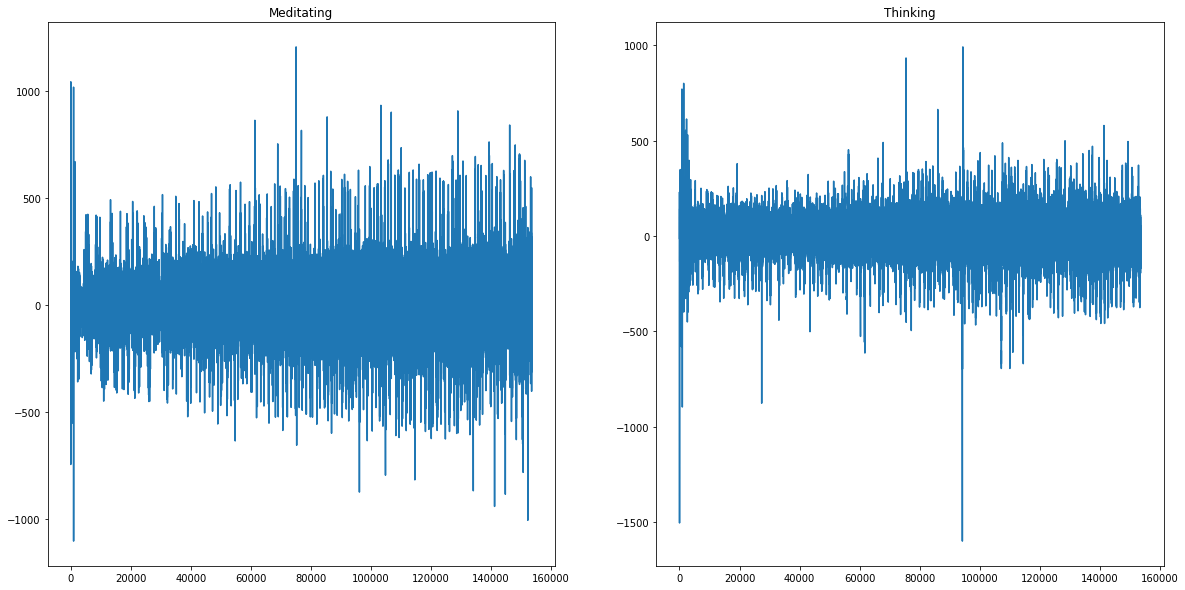

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

thinking_raw = pd.read_csv("./data/meditation-EEG/thinking.csv")[["FP2-F4"]]
thinking = thinking_raw[thinking_raw["FP2-F4"] != "FP2-F4"].astype("int")
meditating_raw = pd.read_csv("./data/meditation-EEG/meditating.csv")[["FP2-F4"]]
meditating = meditating_raw[meditating_raw["FP2-F4"] != "FP2-F4"].astype("int")

plt.rcParams["figure.figsize"] = (20, 10)
plt.subplot(1, 2, 1)
plt.plot(meditating)
plt.title("Meditating")
plt.subplot(1, 2, 2)
plt.plot(thinking)
plt.title("Thinking")
plt.show()

In [2]:
def print_stats(df):
    print("size:", df.shape[0])
    print("mean:", df.mean()[0])
    print("range:", df.min()[0], "-", df.max()[0])
    print("std dev:", df.std()[0])

print("Thinking ===")
print_stats(thinking)
print("\nMeditating ===")
print_stats(meditating)

Thinking ===
size: 153600
mean: -0.63021484375
range: -1599 - 992
std dev: 90.44913599337112

Meditating ===
size: 153600
mean: -0.5788020833333334
range: -1103 - 1206
std dev: 121.46462892405866


Mean period: 7.518233883205247
stddev: 2.150585105130742


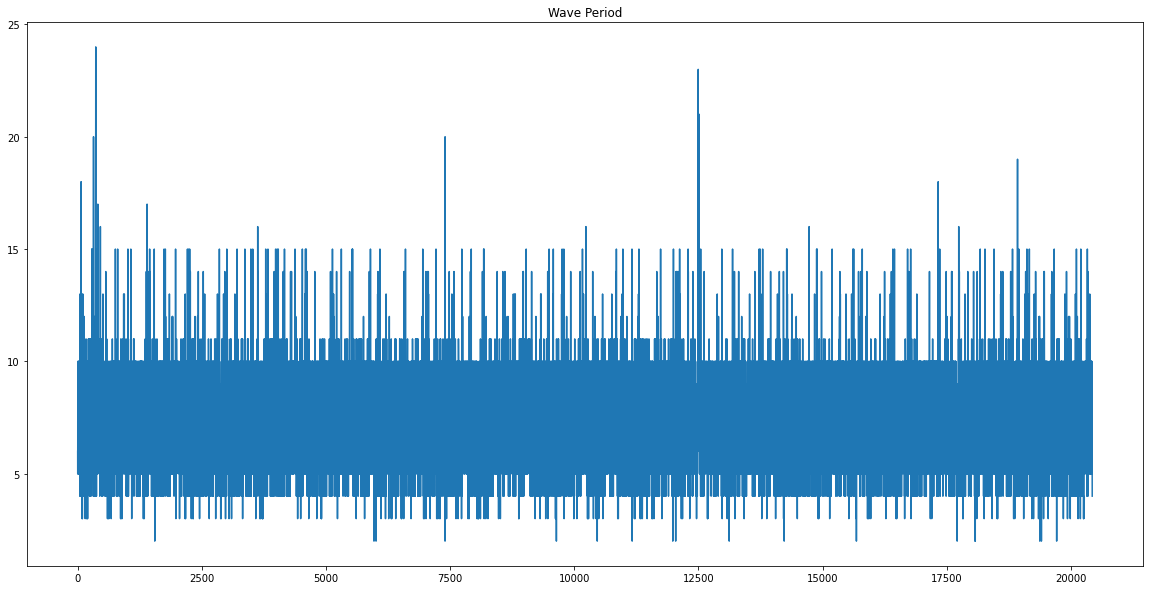

In [3]:
from scipy.signal import find_peaks

def get_period(arr):
    peak_indices, _ = find_peaks(arr)
    periods = np.diff(peak_indices)
    avg_period = periods.mean()
    return periods, avg_period

thinking_periods, avg_thinking_period = get_period(thinking["FP2-F4"])
meditating_periods, avg_meditating_period = get_period(meditating["FP2-F4"])

print("Mean period:", avg_thinking_period)
print("stddev:", thinking_periods.std())
plt.plot(thinking_periods)
plt.title("Wave Period")
plt.show()

In [4]:
from sklearn.preprocessing import MinMaxScaler

print(thinking.shape)

# Scale data
thinking_scaler = MinMaxScaler()
meditating_scaler = MinMaxScaler()
thinking_scaled = thinking_scaler.fit_transform(thinking)
meditating_scaled = meditating_scaler.fit_transform(meditating)

(153600, 1)


# Dataset 2

The previous dataset did not have timestamps attached to samples and the sample rate is unknown, which limits the usability of the data. We'll turn our focus on an OpenBCI dataset with timestamps for each data point, as well as additional EEG sensor data.

In [5]:
openbci_raw = pd.read_csv("./data/OpenBCI-RAW/OpenBCI-RAW-2020-03-05_13-51-53.csv")

# Add time_since_start row if not already present
if not "time_since_start" in openbci_raw:
    from dateutil.parser import parse as date_parse
    import datetime
    import calendar
    
    start_time = date_parse(openbci_raw["time"][0])
    
    def add_time_since_start_column(row):
        time = date_parse(row["time"])
        time_diff = time - start_time
        row["time_since_start"] = time_diff.total_seconds() * 1000
        return row

    openbci_raw = openbci_raw.apply(add_time_since_start_column, axis=1)

    openbci_raw.to_csv("./data/OpenBCI-RAW/OpenBCI-RAW-2020-03-05_13-51-53.csv")

openbci_raw.head(10)

,Unnamed: 0,sample_id,eeg1,eeg2,eeg3,eeg4,accelerometer1,accelerometer2,accelerometer3,time,aux_unknown,time_since_start
0,0,0,10.91,-46.04,-243.03,-127.65,0.624,0.384,-0.704,13:52:30.485,1583437950485,0.0
1,1,1,-58.28,-36.05,-220.77,-114.20,0.624,0.384,-0.704,13:52:30.505,1583437950505,20.0
2,2,2,10.48,-19.08,-196.98,-94.71,0.624,0.384,-0.704,13:52:30.505,1583437950505,20.0
3,3,3,71.48,-19.59,-194.40,-96.10,0.624,0.384,-0.704,13:52:30.532,1583437950532,47.0
4,4,4,51.69,-53.83,-195.87,-103.38,0.624,0.384,-0.704,13:52:30.532,1583437950532,47.0
5,5,5,-3.13,-95.46,-196.46,-87.13,0.624,0.384,-0.704,13:52:30.534,1583437950534,49.0
6,6,6,-13.13,-108.54,-199.38,-90.09,0.608,0.368,-0.704,13:52:30.534,1583437950534,49.0
7,7,7,31.53,-88.99,-205.15,-84.99,0.608,0.368,-0.704,13:52:30.542,1583437950542,57.0
8,8,8,55.24,-70.98,-212.35,-98.91,0.608,0.368,-0.704,13:52:30.542,1583437950542,57.0
9,9,9,43.42,-30.47,-220.73,-109.27,0.608,0.368,-0.704,13:52:30.542,1583437950542,57.0


First, we'll look at the datasets overlaid on each other.

Note EEG 1 and EEG 2 are closely related, but EEG 2 has a much greater range, with an extreme valley around the 100-200th sample. EEG 3 is correlated to 1 and 2, as expected, but the value is lower on average, and has a lower standard deviation, both by about 75%.

eeg1 =====
Shape: (126871,)
Mean: 38.753229868380245
Std Dev: 38.753229868380245
eeg2 =====
Shape: (126871,)
Mean: 41.05240394184276
Std Dev: 41.05240394184276
eeg3 =====
Shape: (126871,)
Mean: 30.24958713521316
Std Dev: 30.24958713521316


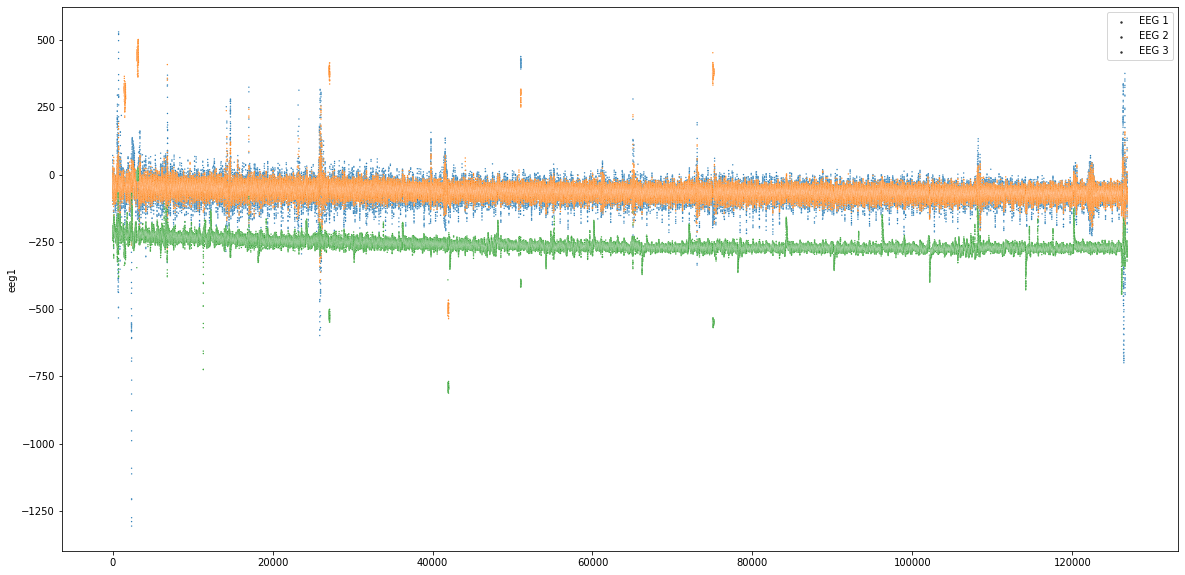

In [6]:
data_len  = openbci_raw.shape[0]

for i in range(1, 4):
    key = "eeg" + str(i)
    print (key + " =====")
    print("Shape:", openbci_raw[key].shape)
    print("Mean:", openbci_raw[key].std())
    print("Std Dev:", openbci_raw[key].std())
    sns.scatterplot(x=np.arange(0, data_len), y=key,
                    data=openbci_raw,
                    size=np.full(data_len, "EEG " + str(i)), sizes=[2.])

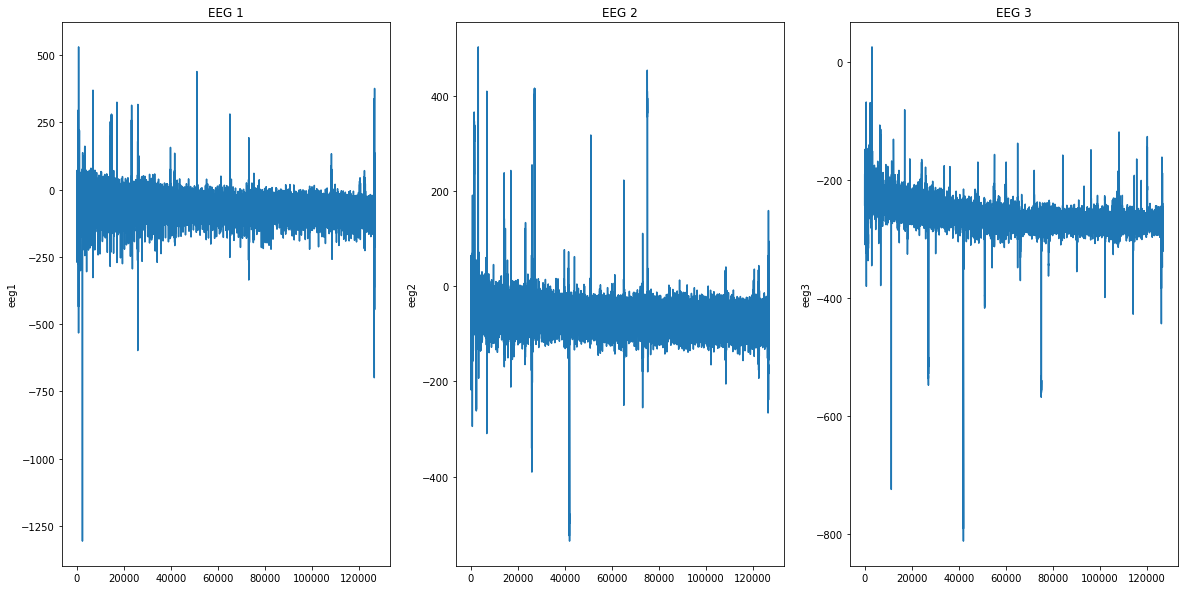

In [7]:
fig, axes = plt.subplots(1, 3)

for i in range(1, len(axes)+1):
    sns.lineplot(x=np.arange(0, openbci_raw.shape[0]), y=openbci_raw["eeg" + str(i)],
                 data=openbci_raw, ax=axes[i-1])\
        .set(title="EEG " + str(i))

[Text(0.5, 1.0, 'EEG 1 zoomed')]

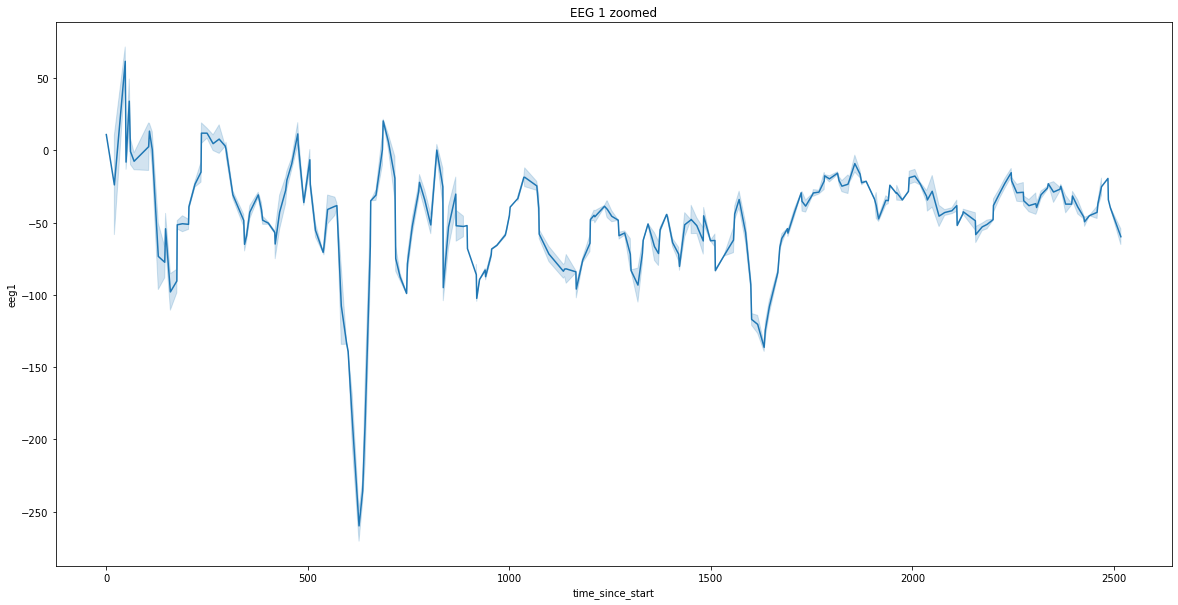

In [8]:
# Let's zoom in

sns.lineplot(x=openbci_raw.loc[0:500, "time_since_start"], y=openbci_raw.loc[0:500, "eeg1"])\
        .set(title="EEG 1 zoomed")

Because all three of these values are in the same unit, we will scale them using the same scaler.

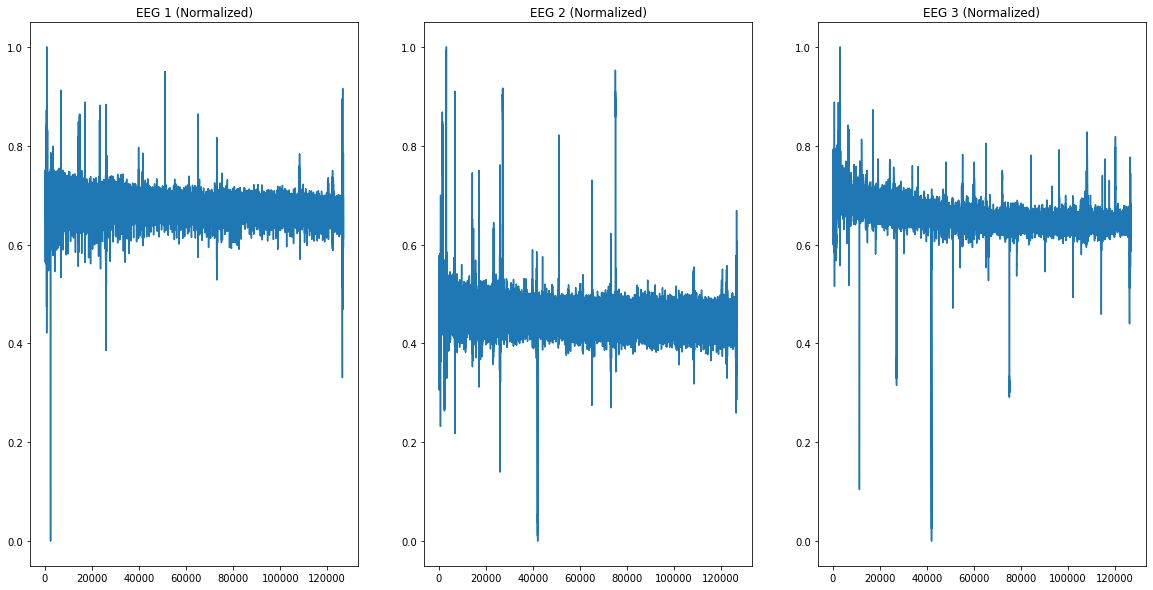

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
openbci_eeg_scaled_list = [scaler.fit_transform(pd.DataFrame(openbci_raw["eeg" + str(i)].T)) for i in range(1, 4)]

fig, axes = plt.subplots(1, len(openbci_eeg_scaled_list))

for i, openbci_eeg_scaled in zip(range(0, len(openbci_eeg_scaled_list)), openbci_eeg_scaled_list):
    sns.lineplot(x=np.arange(0, openbci_eeg_scaled.shape[0]), y=openbci_eeg_scaled[:, 0], ax=axes[i])\
        .set(title="EEG " + str(i+1) + " (Normalized)")

## Remove drift

The mean of the data changes over time. This is called drift. We can remove this trend in the data using scipy's detrend function.

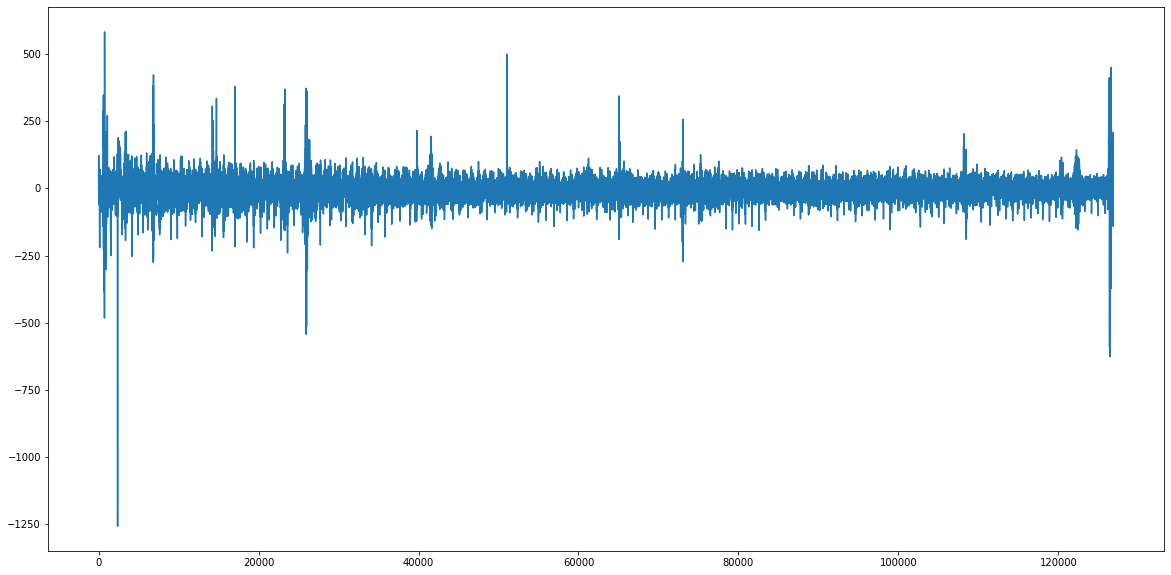

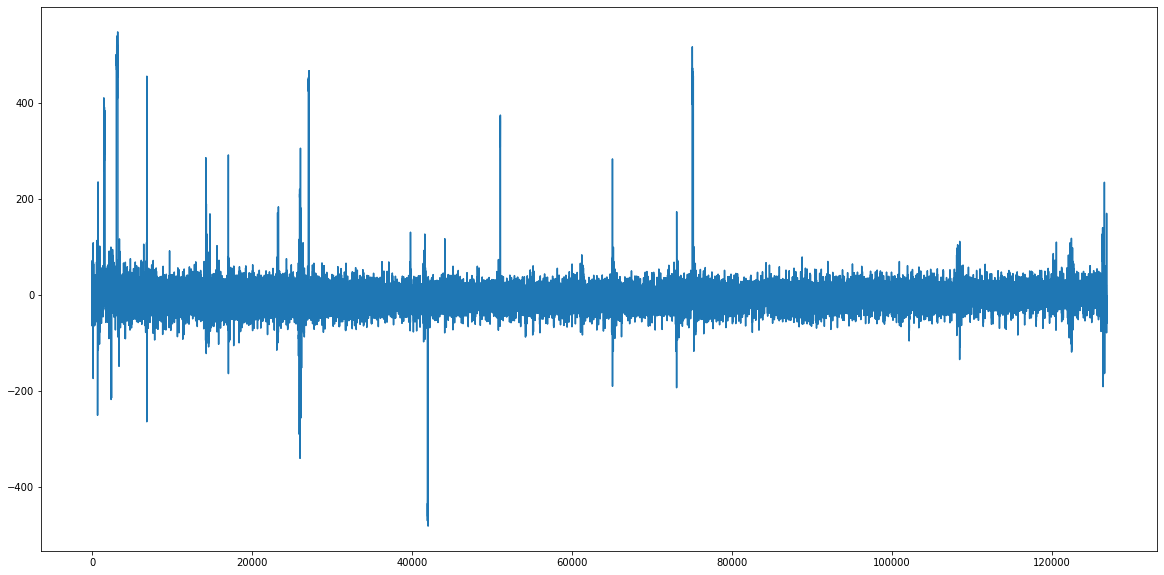

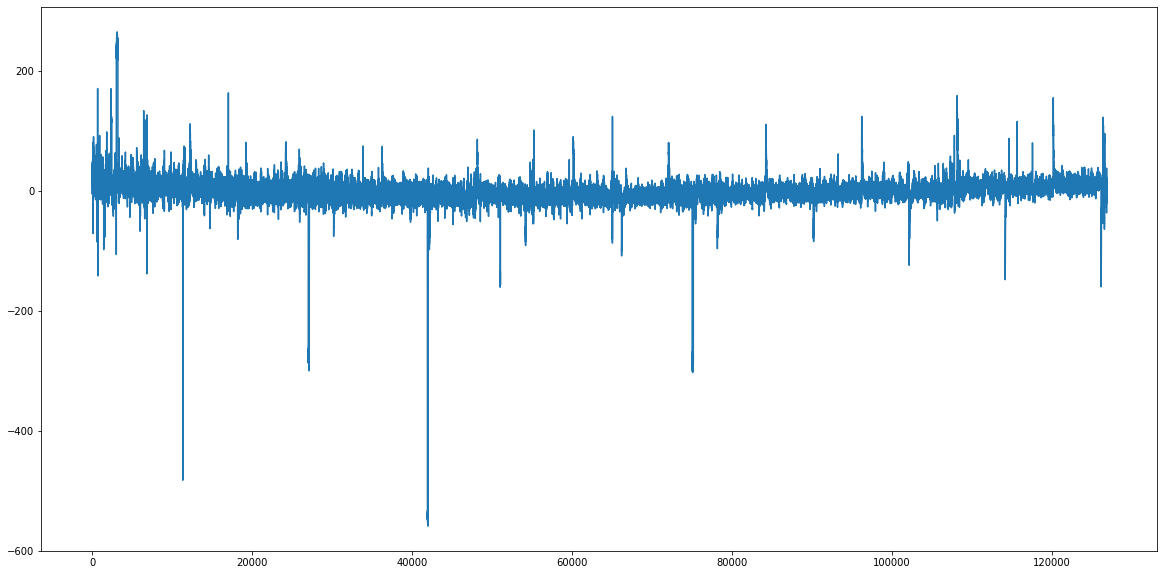

In [10]:
from scipy.signal import detrend

openbci_raw.loc[:, "eeg1"] = detrend(openbci_raw.loc[:, "eeg1"])
openbci_raw.loc[:, "eeg2"] = detrend(openbci_raw.loc[:, "eeg2"])
openbci_raw.loc[:, "eeg3"] = detrend(openbci_raw.loc[:, "eeg3"])

for i in range(0, 3):
    data = openbci_raw.loc[:, "eeg" + str(i+1)]
    plt.plot(np.arange(0, data.shape[0]), data)
    plt.show()
    #sns.lineplot(x=np.arange(0, data.shape[0]), y=data, ax=axes[i])\
    #    .set(title="EEG " + str(i+1) + " (after detrend)")

## Remove 60 Hz Noise

Any time a signal is recorded inside of a building, there will be a prominent 60 Hz noise from the power lines. We will remove this using a notch filter.

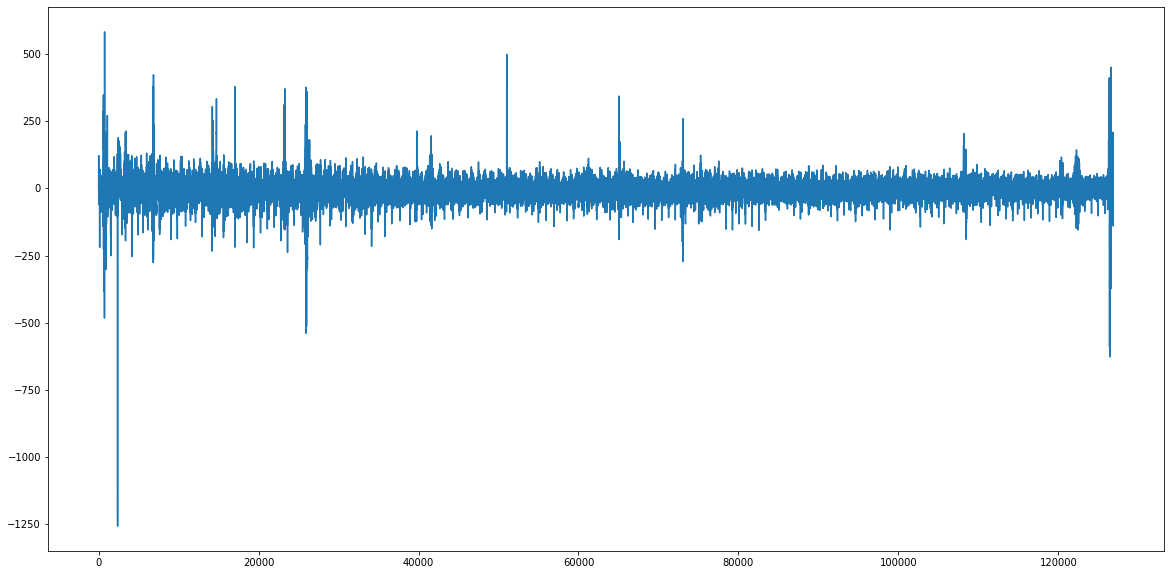

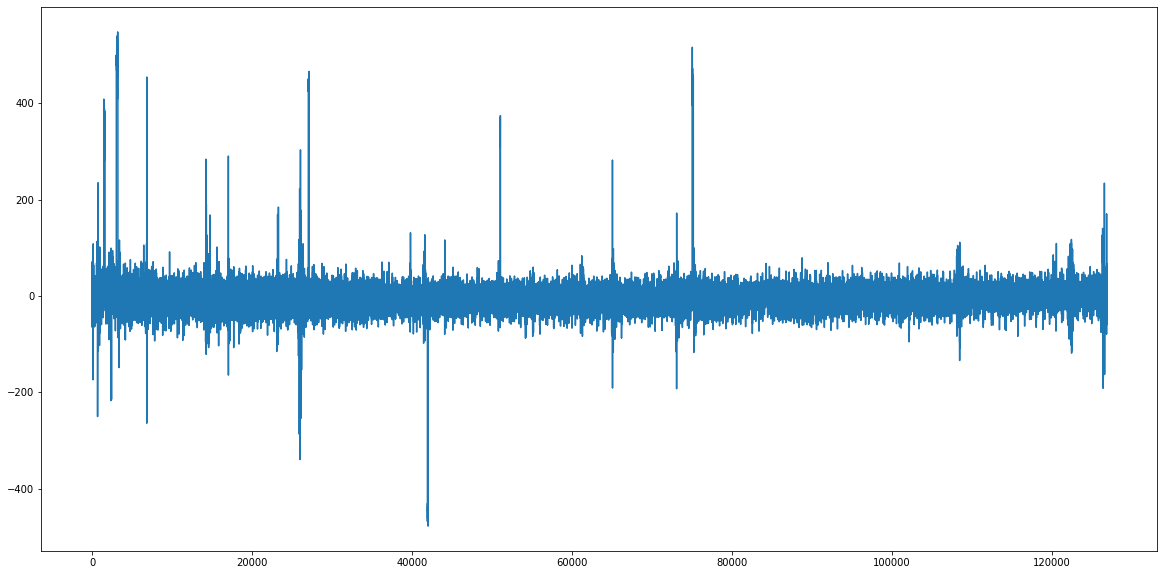

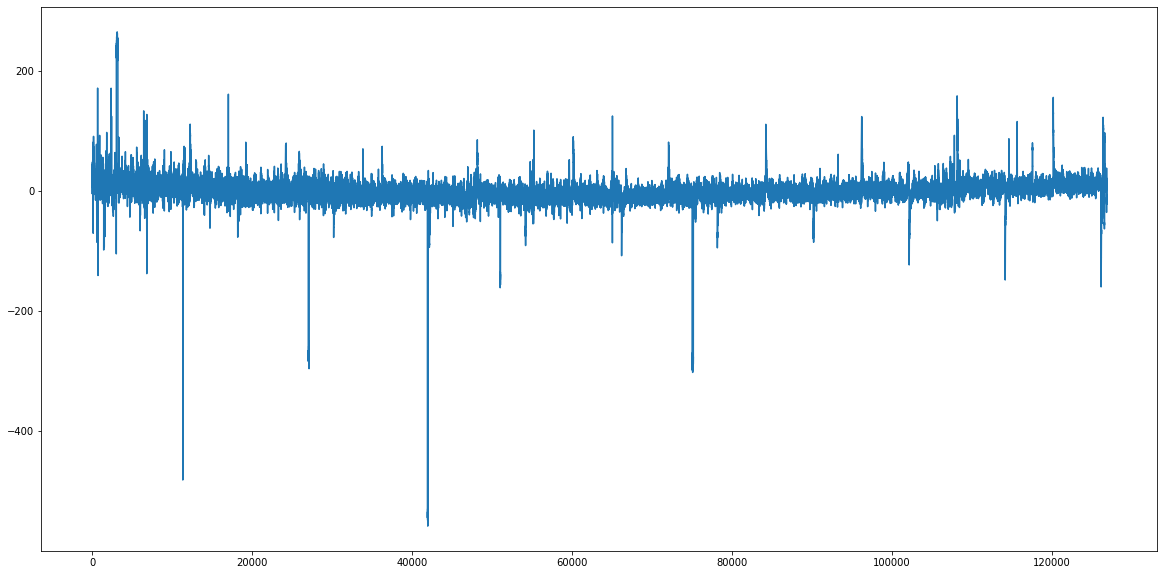

In [11]:
import scipy.signal as ss

b, a = ss.iirnotch(60.0, 200.0, 200.)

openbci_raw.loc[:, "eeg1"] = ss.filtfilt(b, a, openbci_raw.loc[:, "eeg1"])
openbci_raw.loc[:, "eeg2"] = ss.filtfilt(b, a, openbci_raw.loc[:, "eeg2"])
openbci_raw.loc[:, "eeg3"] = ss.filtfilt(b, a, openbci_raw.loc[:, "eeg3"])

for i in range(0, 3):
    data = openbci_raw.loc[:, "eeg" + str(i+1)]
    plt.plot(np.arange(0, data.shape[0]), data)
    plt.show()

# Detecting Brainwave Frequency

Next, we will detect the average brainwave frequency for any given sequence of samples, and classify it as alpha (8-12 Hz), beta (13-30 Hz), theta (4-8 Hz), low gamma (30-70 Hz), high gamma (70-150 Hz).

In [12]:
from scipy.signal import find_peaks

def calculate_period(key, samplerange):
    peak_indices, _ = find_peaks(openbci_raw.loc[samplerange[0]:samplerange[1], key])
    peak_times = openbci_raw.loc[samplerange[0]:samplerange[1], "time_since_start"].iloc[peak_indices]
    periods = np.diff(peak_times)
    return periods.mean(), periods.std(), len(peak_times), periods

def calculate_frequency(key, samplerange):
    mean_period, _, _, periods = calculate_period(key, samplerange)
    return 1000 / mean_period, 1000 / periods

print(calculate_frequency("eeg1", (0, None)))
print(calculate_frequency("eeg2", (0, None)))
print(calculate_frequency("eeg3", (0, None)))

# TODO: plot line of eeg1, scatter plot of peaks, scatter of periods  

(48.48180020749309, array([100.        , 333.33333333,  22.22222222, ...,  18.51851852,
       166.66666667,  15.625     ]))
(50.15190140833968, array([ 25.        ,  22.22222222, 500.        , ...,  40.        ,
        22.22222222,  34.48275862]))
(54.589369695765754, array([ 100.        ,   20.83333333,  500.        , ...,   16.39344262,
       1000.        ,   66.66666667]))


<ipython-input-12-8a96f89522a6>:11: RuntimeWarning: divide by zero encountered in true_divide
  return 1000 / mean_period, 1000 / periods


loss: 0.014286379604423888


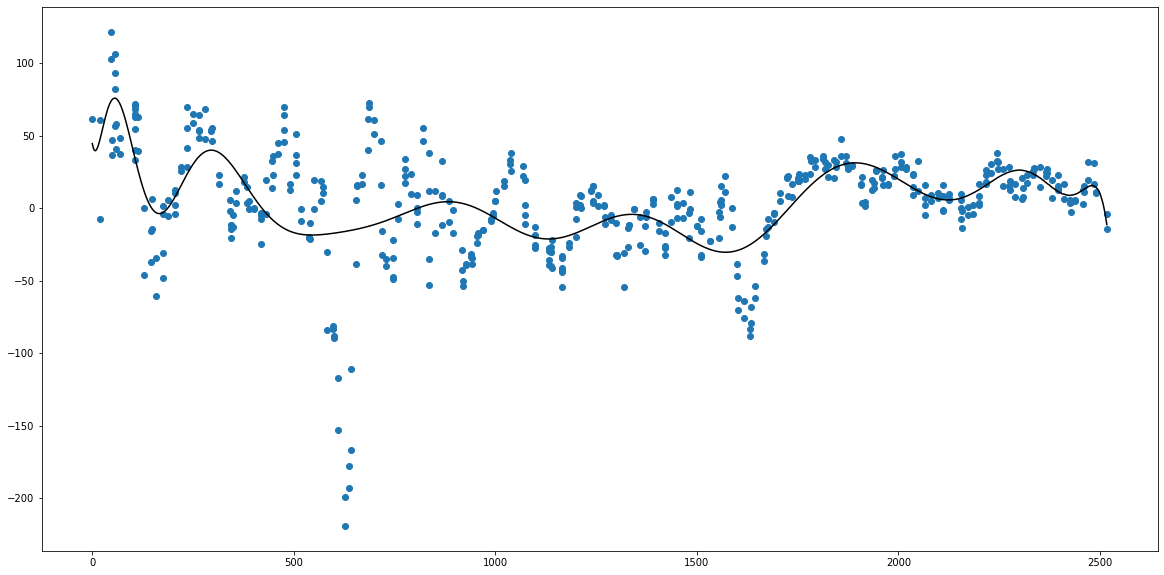

In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def lin_reg_plot(x_feature, y_feature, data=openbci_raw, x_label=None, y_label=None, degree=None):
    # Create scalers
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    # Filter out rows that don't have the features we need
    notnull_mask = data[x_feature].notnull() & data[y_feature].notnull()
    notnull_data = data[notnull_mask]

    # Scale data
    X_scaled = x_scaler.fit_transform(notnull_data[[x_feature]])
    y_scaled = y_scaler.fit_transform(notnull_data[[y_feature]])

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.25)

    # Determine the optimal degree, or use provided degree,
    # then create the model
    min_err, optimal_degree, optimal_model = 1., None, None
    if degree == None:
        for degree in range(1, 10):
            polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
            polyreg.fit(X_train, y_train)

            y_test_pred = polyreg.predict(X_test)
            err = mean_squared_error(y_test, y_test_pred)
            if err < min_err:
                min_err = err
                optimal_degree = degree
                optimal_model = polyreg
                
        print("optimal degree:", optimal_degree)
    else:
        polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        polyreg.fit(X_train, y_train)

        y_test_pred = polyreg.predict(X_test)
        err = mean_squared_error(y_test, y_test_pred)
        min_err = err
        optimal_degree = degree
        optimal_model = polyreg

    print("loss:", min_err)

    # Create a smooth curve to plot
    X_test = np.linspace(0, 1, 1000).reshape(-1, 1)
    y_test_pred = optimal_model.predict(X_test)

    plt.figure()
    plt.scatter(x_scaler.inverse_transform(X_scaled), y_scaler.inverse_transform(y_scaled))
    plt.plot(x_scaler.inverse_transform(X_test), y_scaler.inverse_transform(y_test_pred), color="black")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
lin_reg_plot("time_since_start", "eeg1", degree=20, data=openbci_raw.loc[:500])

## Fourier Transform

The fourier transform takes a complex signal and breaks it down into its individual frequencies. This is exactly what we need - we want to find various types of brainwaves and classify them.

(301,)


Text(0, 0.5, 'Mean band Amplitude')

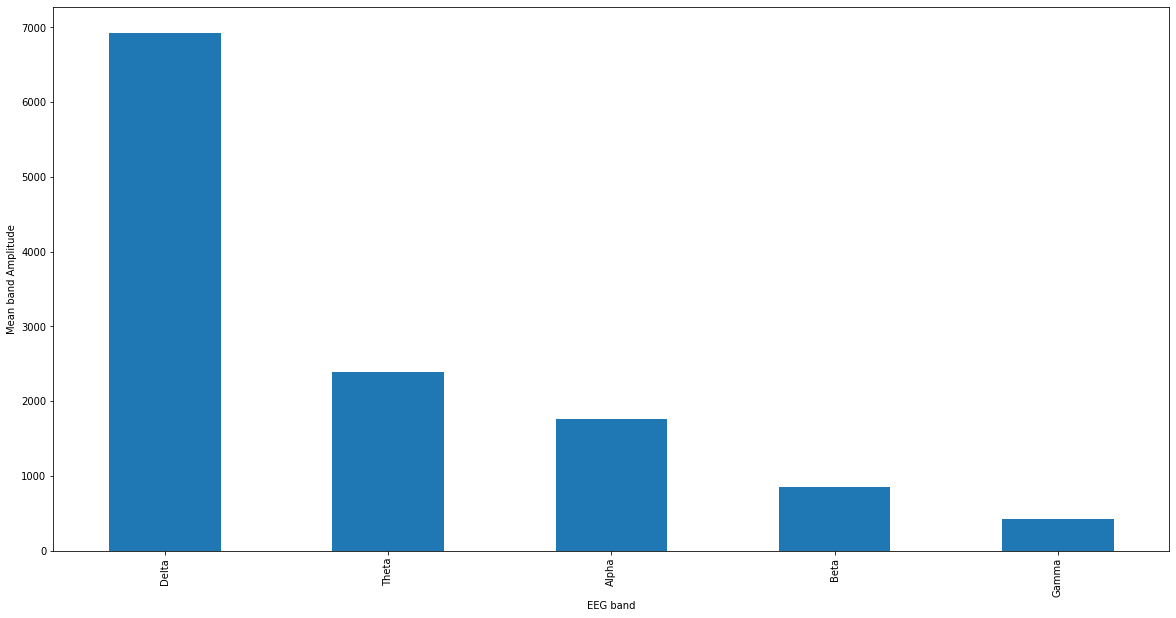

In [14]:
import numpy as np

fs = 200                                # Sampling rate (200 Hz)
data = openbci_raw.loc[:fs*3, "eeg1"] #np.random.uniform(0, 100, fs*10)  # 2 sec of data b/w 0.0-100.0

# Get real amplitudes of FFT (only in postive frequencies)
fft_vals = np.absolute(np.fft.rfft(data))
print(fft_vals.shape)

# Get frequencies for amplitudes in Hz
fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)

# Define EEG bands
eeg_bands = {'Delta': (0, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 45)}

# Take the mean of the fft amplitude for each EEG band
eeg_band_fft = dict()
for band in eeg_bands:
    freq_ix = np.where((fft_freq >= eeg_bands[band][0]) &
                       (fft_freq <= eeg_bands[band][1]))[0]
    eeg_band_fft[band] = np.mean(fft_vals[freq_ix])

# Plot the data (using pandas here cause it's easy)
import pandas as pd
df = pd.DataFrame(columns=['band', 'val'])
df['band'] = eeg_bands.keys()
df['val'] = [eeg_band_fft[band] for band in eeg_bands]
ax = df.plot.bar(x='band', y='val', legend=False)
ax.set_xlabel("EEG band")
ax.set_ylabel("Mean band Amplitude")

(601,) (601,)
9310.849259263567


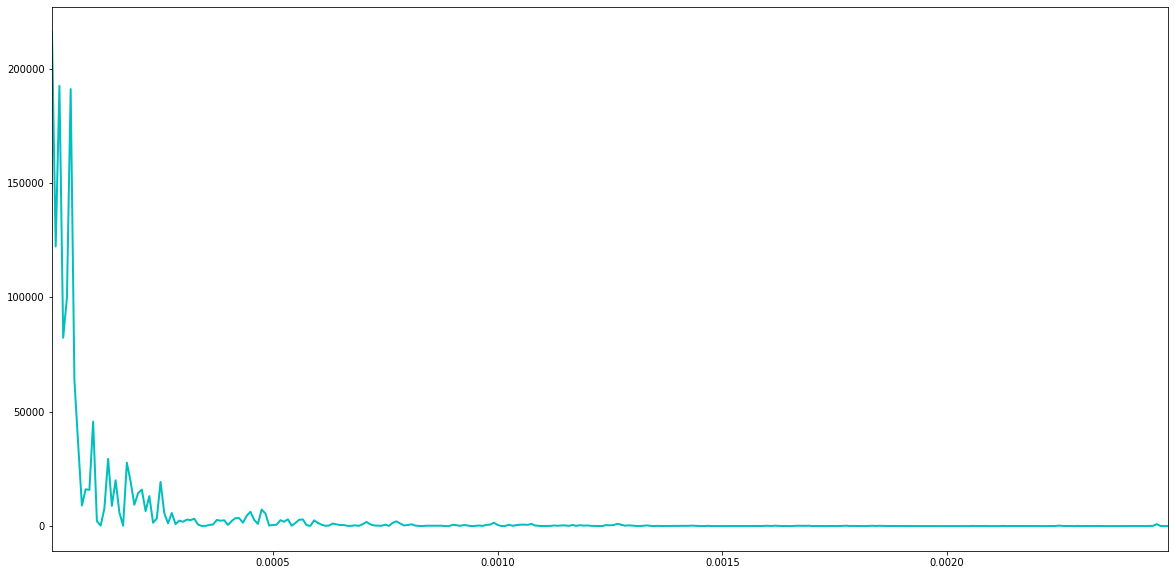

In [15]:
seconds = 3
sample_rate = 200
last_sample_index = sample_rate*seconds
# Array of time values
t = np.linspace(0, seconds, last_sample_index)
# Corresponding eeg values (eeg1)
f = openbci_raw.loc[:last_sample_index, "eeg1"]
# == last_sample_index
n = len(t)

# Do FFT, take only real portion of imaginary vector
fhat = np.abs(np.fft.fft(f))

print(f.shape, fhat.shape)
print(fhat[0])

# Compute power spectral density
power_spectral_density = fhat * np.conj(fhat) / n

# Create x axis of frequencies
freq = (1/(sample_rate*n)) * np.arange(n)
L = np.arange(1, np.floor(n/2), dtype="int")

plt.plot(freq[L], power_spectral_density[L], color='c', linewidth=2, label='Noisy')
plt.xlim(freq[L[0]], freq[L[-1]])
plt.show()

/home/jared/.local/share/virtualenvs/jupyter-test-X3chRXYV/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


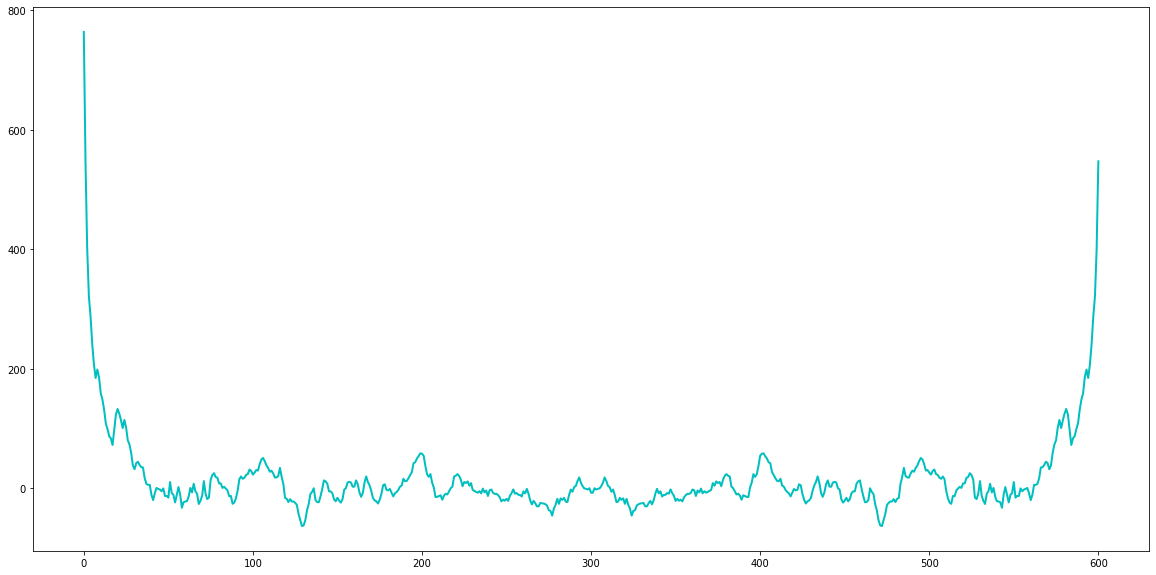

In [16]:
inverse = np.fft.ifft(fhat)

plt.plot(np.arange(len(inverse)), inverse, color='c', linewidth=2, label='Noisy')
plt.show()

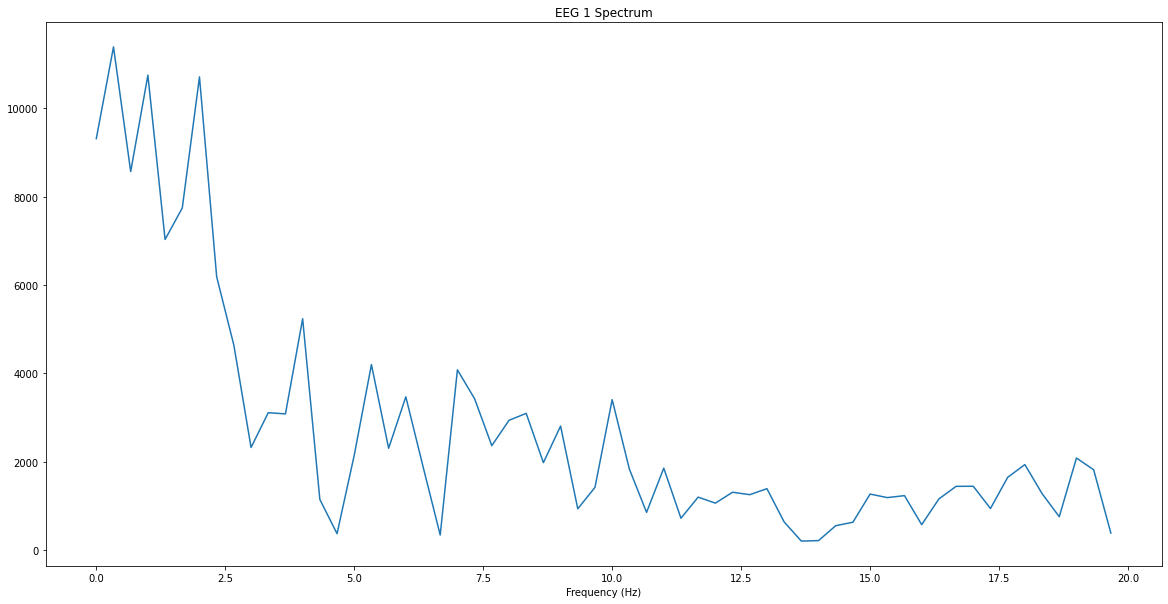

In [17]:
def plot_magnitude_spectrum(signal, title, sample_rate, f_ratio=1):
    signalhat = np.fft.fft(signal)
    magnitude_spectrum = np.abs(signalhat)
    frequency = np.linspace(0, sample_rate, len(magnitude_spectrum))
    num_frquency_bins = int(len(frequency) * f_ratio)
    
    plt.plot(frequency[:num_frquency_bins], magnitude_spectrum[:num_frquency_bins])
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.show()

plot_magnitude_spectrum(openbci_raw.loc[:last_sample_index, "eeg1"], "EEG 1 Spectrum", 200, f_ratio=0.1)

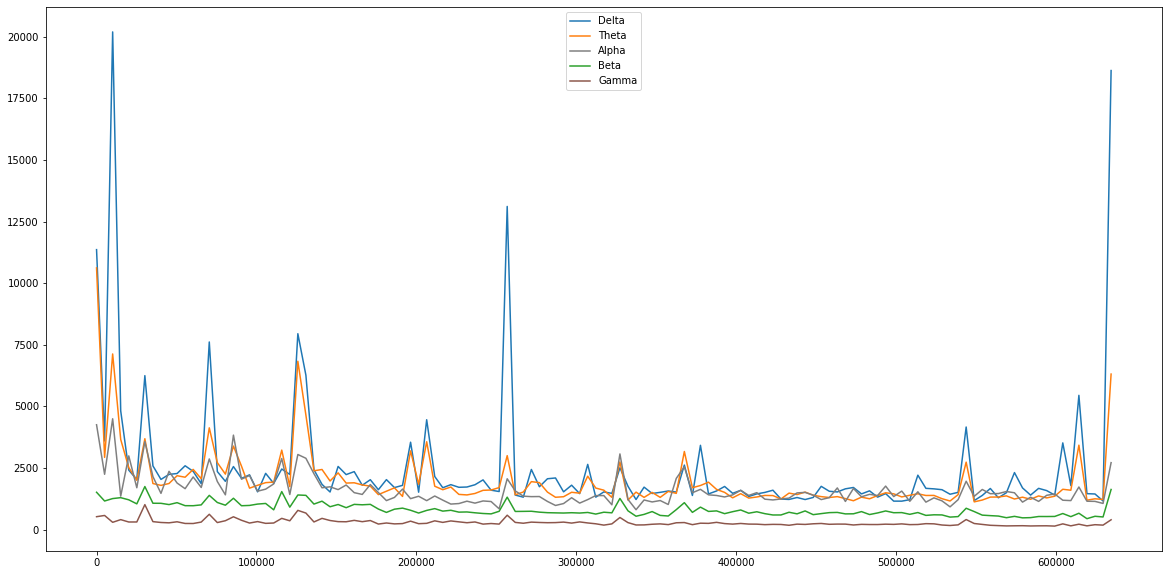

In [18]:
def band_magnitudes(data, sample_rate=200):
    # Get real amplitudes of FFT (only in postive frequencies)
    fft_vals = np.absolute(np.fft.rfft(data))

    # Get frequencies for amplitudes in Hz
    fft_freq = np.fft.rfftfreq(len(data), 1.0/sample_rate)

    # Define EEG bands
    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 45)}

    # Take the mean of the fft amplitude for each EEG band
    eeg_band_fft = dict()
    for band in eeg_bands:
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) &
                           (fft_freq <= eeg_bands[band][1]))[0]
        eeg_band_fft[band] = np.mean(fft_vals[freq_ix])
    
    return eeg_band_fft

#### Plot magnitude of each band over time

def band_magnitude_change(data, frame_size=None, sample_rate=200):
    """
    Get the magnitude of each band over time, using frames
    """
    
    # Default to 2s per frame
    if frame_size == None:
        frame_size = int(sample_rate * 2)
    max_frame = len(data)
    frame_count = int(np.ceil(max_frame / frame_size))

    bands_over_time = {
        'Delta': [],
        'Theta': [],
        'Alpha': [],
        'Beta': [],
        'Gamma': []
    }
    band_keys = list(bands_over_time.keys())

    for frame_i in range(0, frame_count):
        start_frame = frame_i * frame_size
        bands = band_magnitudes(data[start_frame:start_frame+frame_size], sample_rate=sample_rate)
        for band_key in band_keys:
            bands_over_time[band_key].append(bands[band_key])

    # Process into numpy arrays
    for band_key in band_keys:
        bands_over_time[band_key] = np.array(bands_over_time[band_key])
        
    return bands_over_time

def plot_band_magnitude(data, frame_size=None, sample_rate=200):
    bands_over_time = band_magnitude_change(data, frame_size, sample_rate)
    frame_count = len(bands_over_time["Delta"])
    max_time = openbci_raw["time_since_start"].iloc[-1]
    
    band_colors = {
        'Delta': 'tab:blue',
        'Theta': 'tab:orange',
        'Alpha': 'tab:gray',
        'Beta': 'tab:green',
        'Gamma': 'tab:brown'
    }

    # Plot each band
    for band_key in bands_over_time.keys():
        band = bands_over_time[band_key]
        plt.plot(np.linspace(0, max_time, frame_count), band, color=band_colors[band_key], label=band_key)

    plt.legend()
    plt.show()
    
plot_band_magnitude(openbci_raw.loc[:, "eeg1"], frame_size=1000)

(array([ 12001,  12002,  12003, ..., 125999, 126000, 126001]),)


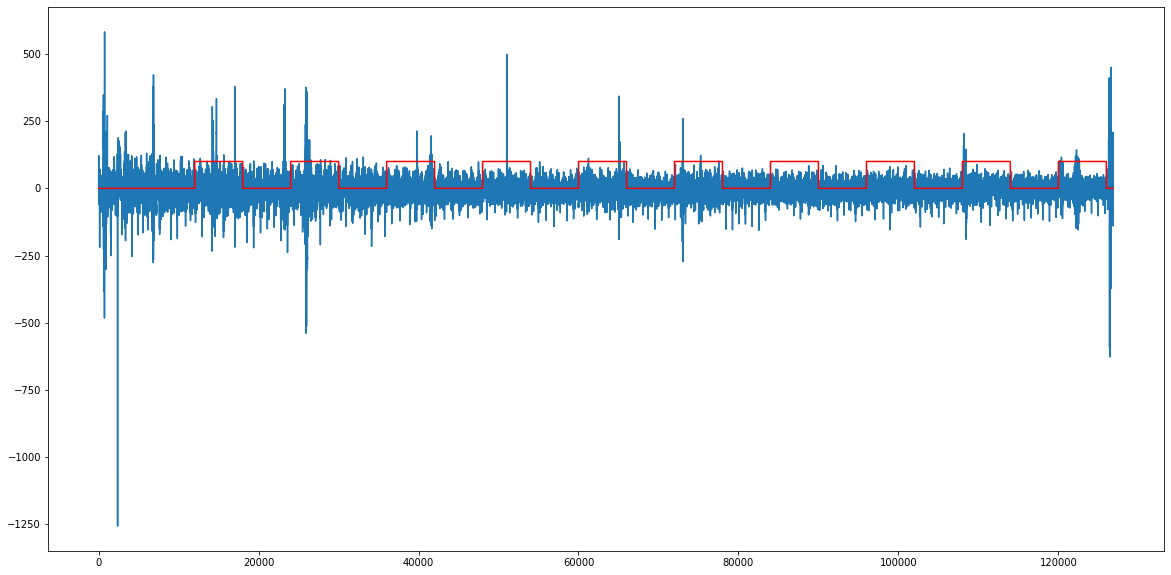

In [19]:
df = openbci_raw

y_labels = np.zeros((df['time_since_start'].shape[0], 1))

# 100 = eyes open
y_labels[(60000<df['time_since_start'])&(df['time_since_start']<90000)] = 1
y_labels[(120000<df['time_since_start'])&(df['time_since_start']<150000)] = 1
y_labels[(180000<df['time_since_start'])&(df['time_since_start']<210000)] = 1
y_labels[(240000<df['time_since_start'])&(df['time_since_start']<270000)] = 1
y_labels[(300000<df['time_since_start'])&(df['time_since_start']<330000)] = 1
y_labels[(360000<df['time_since_start'])&(df['time_since_start']<390000)] = 1
y_labels[(420000<df['time_since_start'])&(df['time_since_start']<450000)] = 1
y_labels[(480000<df['time_since_start'])&(df['time_since_start']<510000)] = 1
y_labels[(540000<df['time_since_start'])&(df['time_since_start']<570000)] = 1
y_labels[(600000<df['time_since_start'])&(df['time_since_start']<630000)] = 1

openbci_raw['eyes_open'] = y_labels

print(np.where(openbci_raw['eyes_open'] == 1))

#plot_band_magnitude(openbci_raw.loc[:, "eeg1"], frame_size=1000)
plt.plot(df['eeg1'])
plt.plot(openbci_raw['eyes_open']*100,'r')
plt.show()

# Neural Regression

We will use PyTorch to see if we can associate the EEG data with whether or not the person's eyes are closed.

126


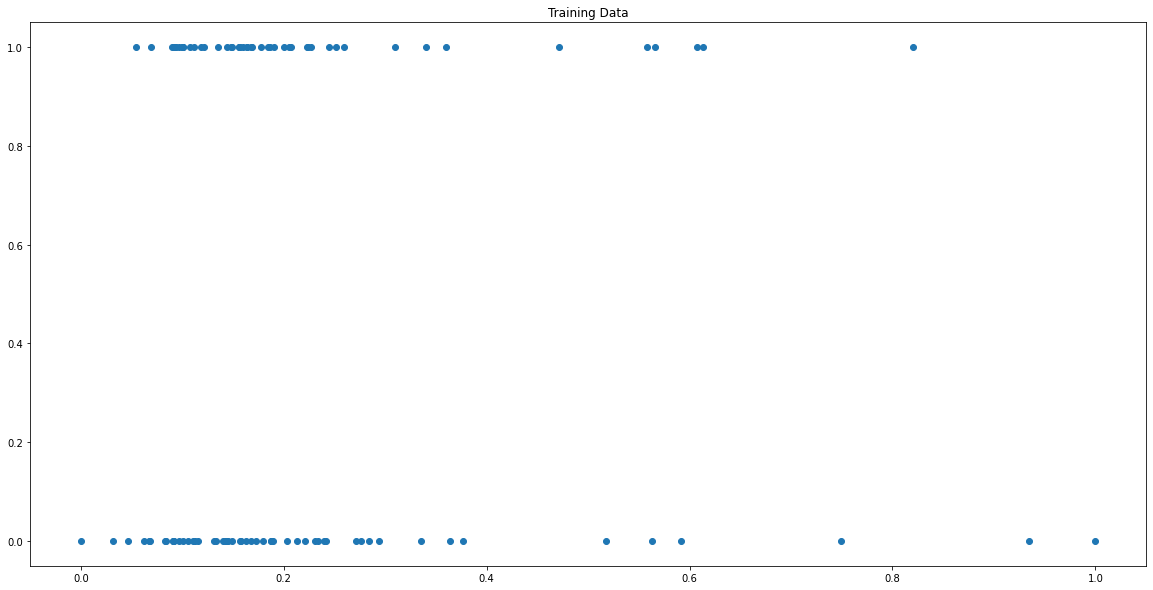

Net(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
)


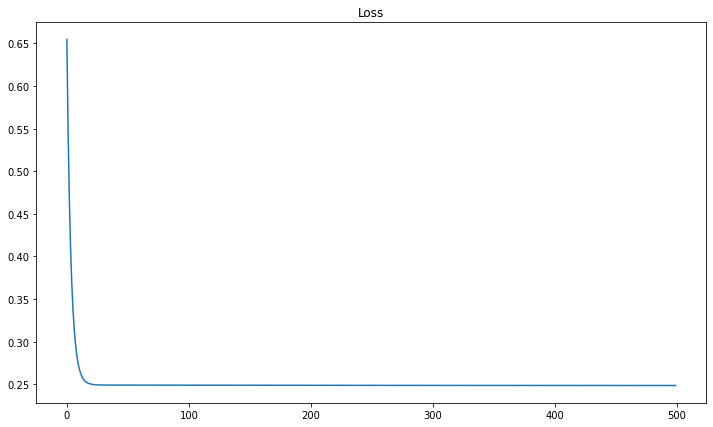

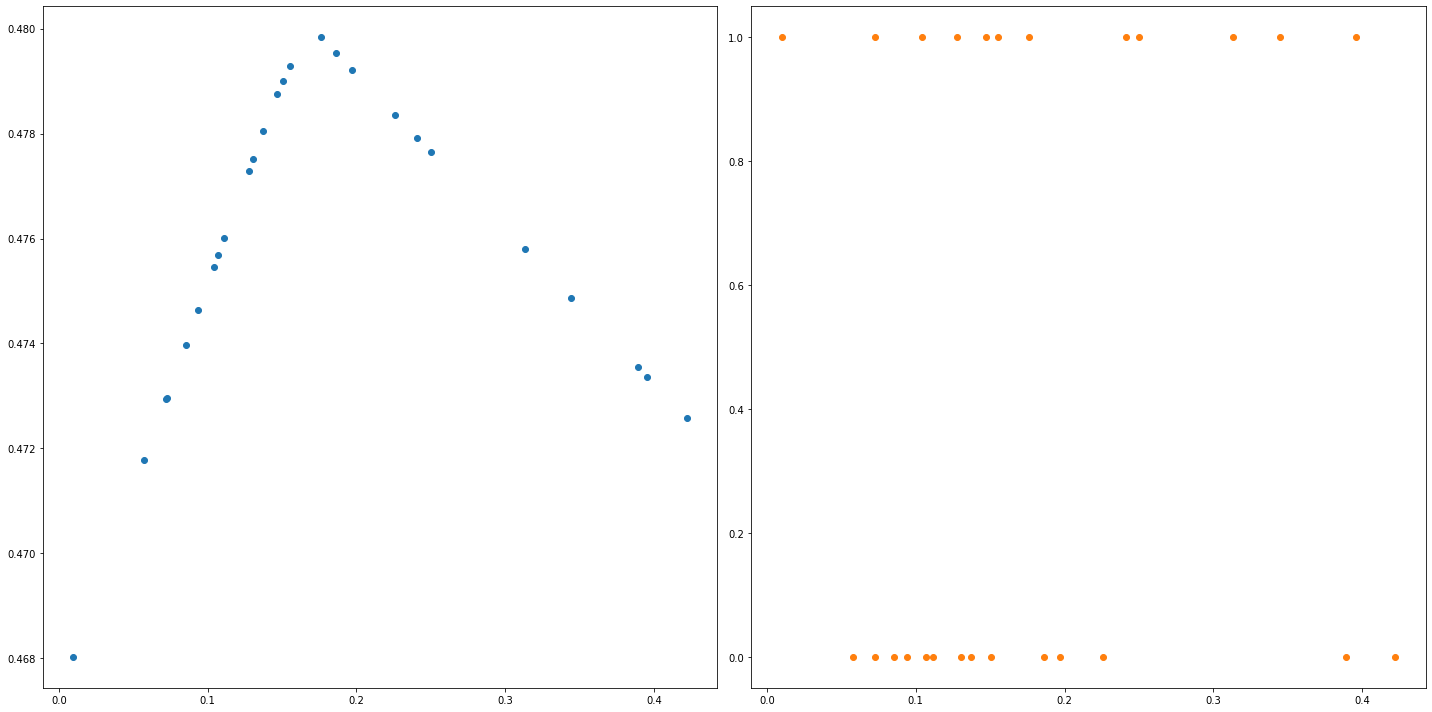

In [68]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
torch.manual_seed(1)    # reproducible

scaler = MinMaxScaler()

sample_rate = 200
frame_length_seconds = 5
frame_size = sample_rate * frame_length_seconds
frame_count = int(len(openbci_raw['eeg1']) / frame_size)

# Get band magnitude samples
band_magnitude_dict = band_magnitude_change(openbci_raw['eeg1'], frame_size=frame_size)

# Scale band magnitudes
for band_key in band_magnitude_dict.keys():
    band_magnitude_dict[band_key] = np.reshape(band_magnitude_dict[band_key], (band_magnitude_dict[band_key].shape[0], 1)) 
    band_magnitude_dict[band_key] = scaler.fit_transform(band_magnitude_dict[band_key])
    
# Create eyes_open array with the same structure as band_magnitudes data
eyes_open = np.zeros((band_magnitude_dict['Alpha'].shape[0], 1))
print(frame_count)
for frame_i in range(0, frame_count):
    start_sample_i = frame_i * frame_size
    end_sample_i = start_sample_i + frame_size, frame_count
    #mean_sample = int(openbci_raw.loc[start_sample_i:start_sample_i+frame_size, 'eyes_open'].mean())
    mid_sample = float(openbci_raw.loc[start_sample_i + frame_size/2, 'eyes_open'])
    eyes_open[frame_i] = mid_sample

x = band_magnitude_dict['Alpha']
y = eyes_open
# Convert to 3d tensors (shape=(seq_len, batch, input_size))
x = x.reshape((x.shape[0], x.shape[1], 1))
y = y.reshape((y.shape[0], y.shape[1], 1))
# Split into train, test
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)
# torch can only train on Variable, so convert them to Variable
x_train, x_test, y_train, y_test = \
    Variable(torch.from_numpy(x_train)), Variable(torch.from_numpy(x_test)),\
    Variable(torch.from_numpy(y_train)), Variable(torch.from_numpy(y_test))

# view data
plt.scatter(x_train, y_train)
plt.title("Training Data")
plt.show()

# this is one way to define a network
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

class NetRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(NetRNN, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

net = Net(n_feature=1, n_hidden=10, n_output=1)
#net = NetRNN(1, 1, 10, 1)
print(net)
optimizer = torch.optim.SGD(net.parameters(), lr=0.03)
loss_func = torch.nn.MSELoss()
loss_list = []

fig, ax = plt.subplots(figsize=(12,7))

# train the network
for t in range(500):
    prediction = net(x_train.float())

    loss = loss_func(prediction, y_train.float())
    loss_list.append(loss.data.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Plot loss
plt.plot(loss_list)
plt.title("Loss")
plt.show()

# test the network
net.eval()

with torch.no_grad():
    prediction = net(x_test.float())
    plt.subplot(1, 2, 1)
    plt.scatter(x_test.float().numpy()[:, 0, 0], prediction.float().numpy()[:, 0, 0])
    plt.subplot(1, 2, 2)
    plt.scatter(x_test.float().numpy()[:, 0, 0], y_test.float().numpy()[:, 0, 0], color='tab:orange')
    plt.tight_layout()
    plt.show()